In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0
%matplotlib inline

Autosave disabled


In [26]:
from MLStructFP_benchmarks.ml.model.architectures import *
from MLStructFP_benchmarks.ml.model.core import *
from MLStructFP_benchmarks.ml.utils import binary_accuracy_metric, iou_metric
from MLStructFP_benchmarks.utils import *
from MLStructFP.db import DbLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm.notebook import tqdm
from matplotlib.ticker import PercentFormatter

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set seed for reproducibility
from numpy.random import seed
seed(1)

## Load data

In [3]:
# Here I assume you stored your session floor plan data within folder .session (see create_data.ipynb for more info)
data = load_floor_photo_data_from_session('.session/no_rot_256_50')

## Create model

In [4]:
model = UNETFloorPhotoModel(data, name='UNET Model')
model.enable_model_checkpoint(epochs=1)

UNET Model: Image shape (256, 256, 1)


In [5]:
# This is only valid after the model was trained and saved as session.
# Once the model is trained, head to "Save the model" at the end of this notebook for saving as a session
model.load_session(f'.session/model_{data.filename}')

Model name:	UNET Model
Save date:	2023-03-05 08:27:33
Train time:	1 day, 21:19:24.553727
Train date:	2023/03/03 10:34:37
Train epochs:	10
Load time:	0.411s


UNET Model
(EARLY STOPPING:OFF) (TEST SPLIT 30.0%)

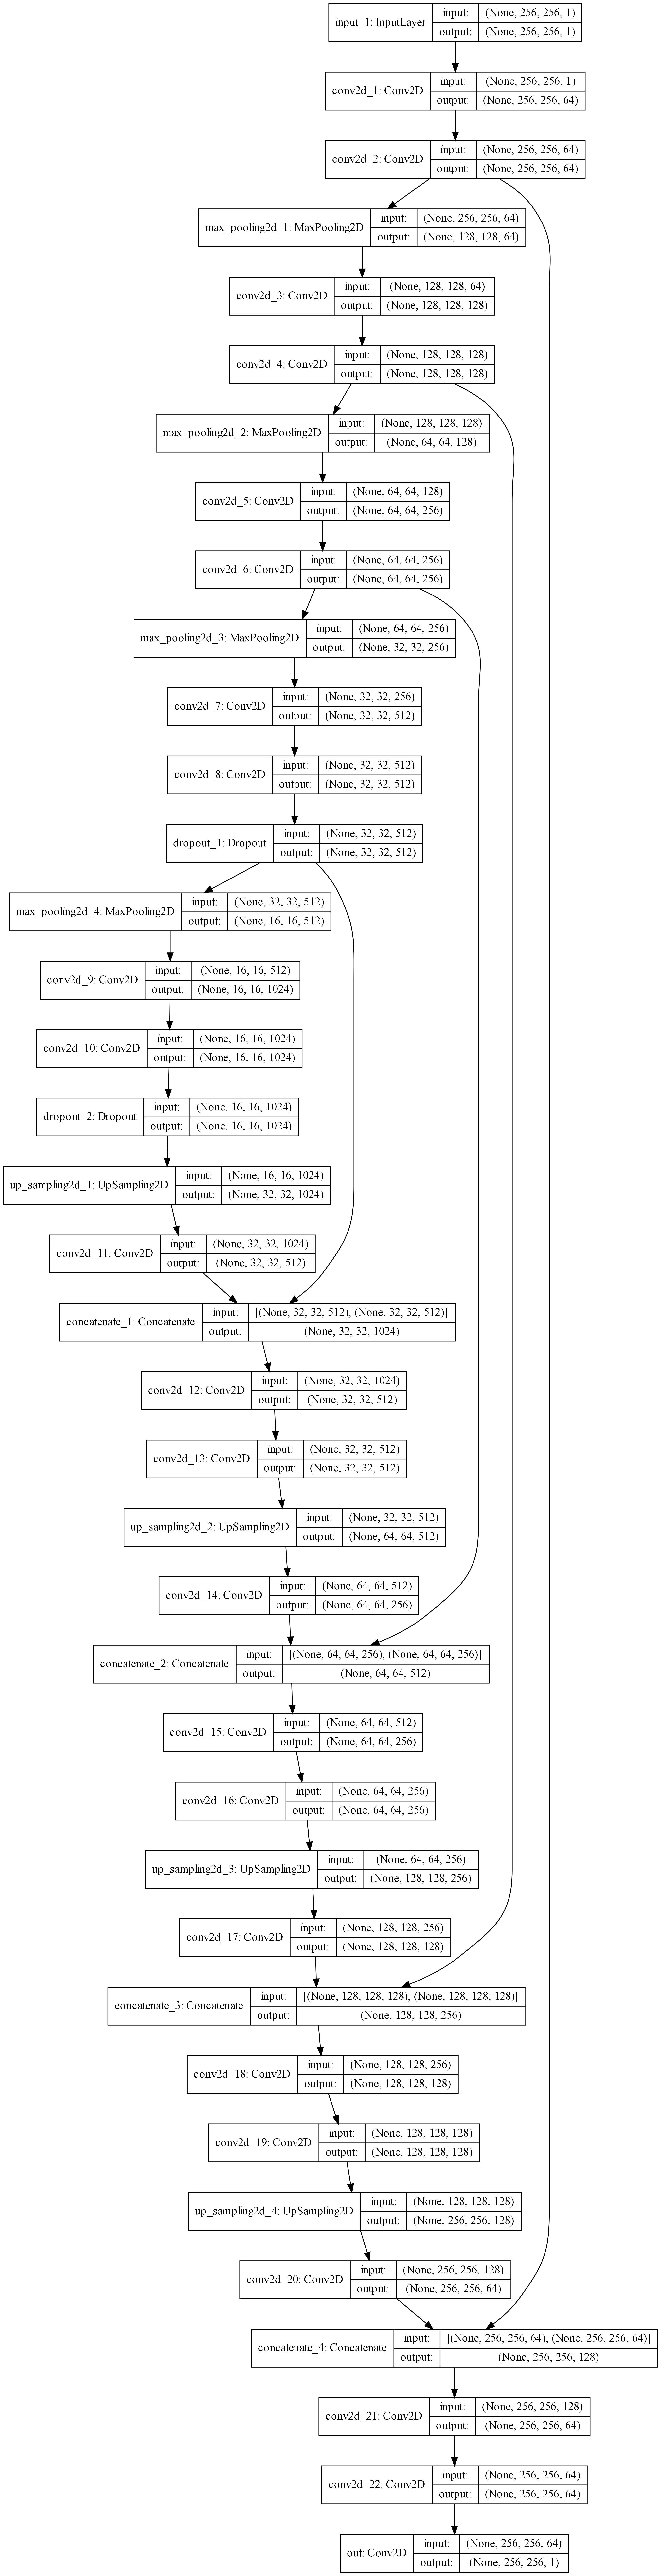

In [6]:
model.plot.architecture(dpi=300, save=False)

In [63]:
model.train(epochs=10, batch_size=2, val_split=0.2)

Evaluation samples: 3
Loading data part 1/1
[Callback] Using TQDM notebook
[Callback] Using model checkpoint, path: .checkpoint\unet_model\2023-03-12_08-31-40\ at 1 epochs mode auto
[Callback] Using model CSV logger, file: .logs\unet_model_2023-03-12_08-31-40.csv

Train initialized at: 2023/03/12 08:31:40
Train shape: (31143, 64, 64, 1) -> (31143, 64, 64, 1)
Train shuffle: True
Train epochs: 10 with batch size 2
Train validation partition: 20.0%

Metrics: ['loss', 'iou', 'accuracy']
Stateful metrics: ['iou', 'accuracy']
Using: Standard fit by tensor


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/24914 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/24914 [00:00<?, ?it/s]

Process finished in: 1:37:10.106008


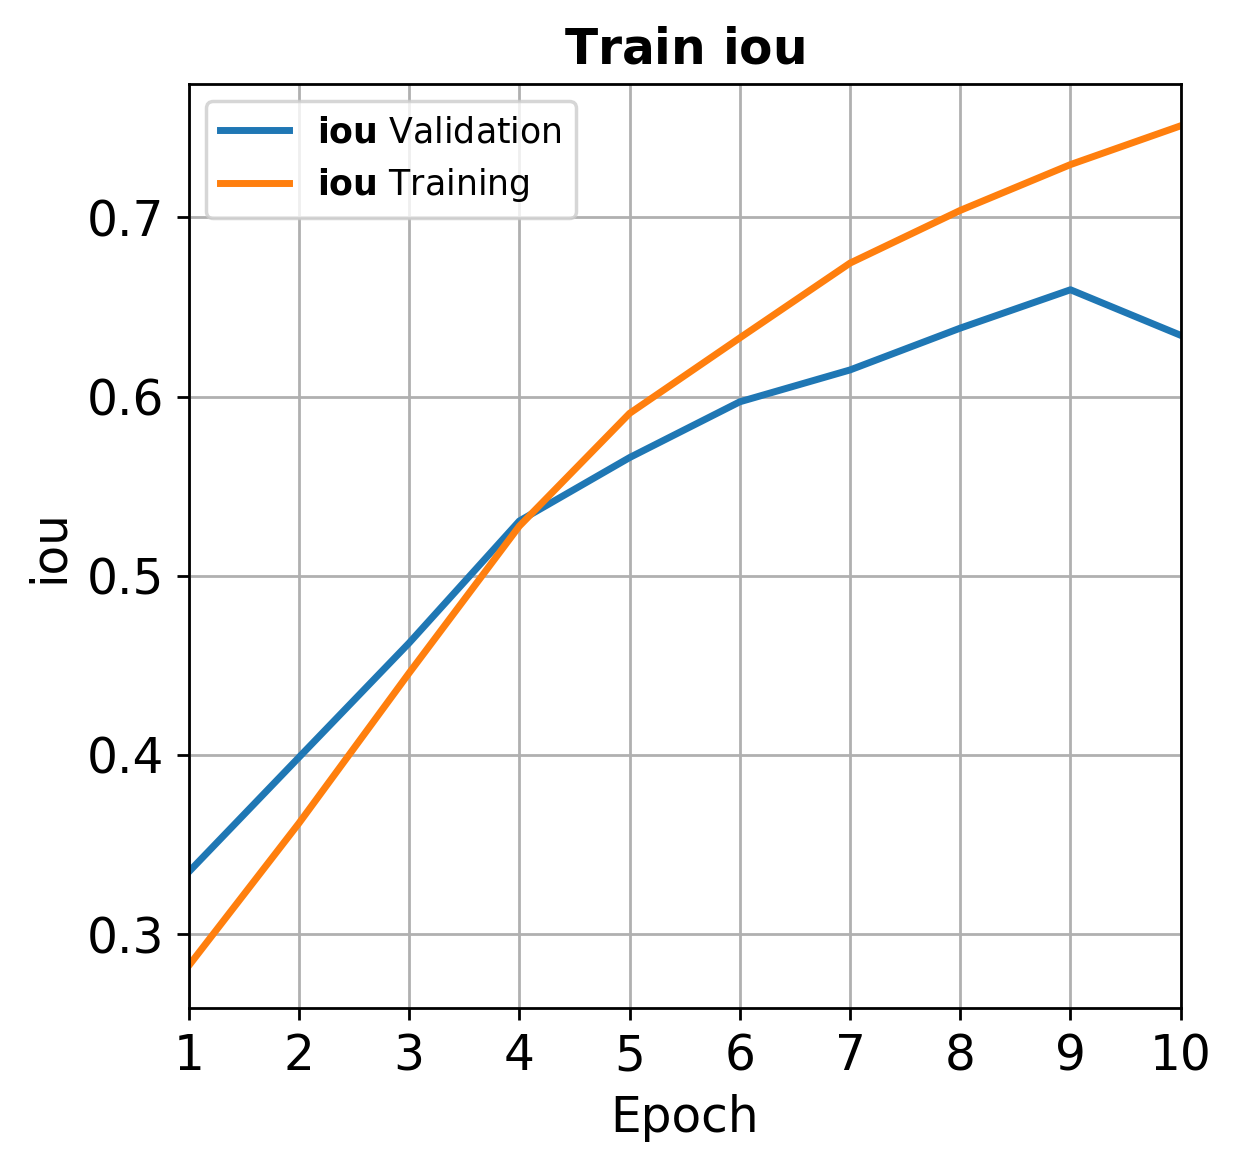

In [64]:
model.plot.train_metrics('iou')

In [ ]:
model.plot.summarize_performance(1)

In [142]:
# model.reset_train()

Resetting weights


## Evaluation

In [6]:
db = DbLoader('dataset/fp.json')
test_data = data.load_part(2, False)

def plot_test(idx: int, title: bool = True) -> None:
    img_in = test_data['photo'][idx]
    img_true = test_data['binary'][idx]
    print(f'IoU: {iou_metric(img_true, model.predict_image(img_in)):.2f}')
    model.plot.plot_predict(img_in, img_true, threshold=False, title=title)

def plot_full(plan_idx: int, patch_size: float):
    plan_id = data._split[1][plan_idx] # Consider only test floor plans
    for f in db.floors:
        if f.id == plan_id:
            patchgen = FloorPatchGenerator(image_size=model._image_shape[0], patch_size=patch_size, bw=True)
            patchgen.plot_patches(f, photo=1, patches=False, rect=False, axis=False,
                                  save=f'.out/full/{plan_idx}_c.png')
            patchgen.plot_patches(f, photo=1, patches=False, rect=True, rect_color='#ff00ff', axis=False,
                                  save=f'.out/full/{plan_idx}_a.png')
            patchgen.plot_patches(f, photo=1, patches=False, rect=False, model=model, axis=False,
                                  save=f'.out/full/{plan_idx}_b.png')
            patchgen.plot_model(f, model, f'.out/model/{f.id}.png', outline=False)
            patchgen.plot_model(f, model, f'.out/model/{f.id}_outline.png', outline=True)

IoU: 0.00


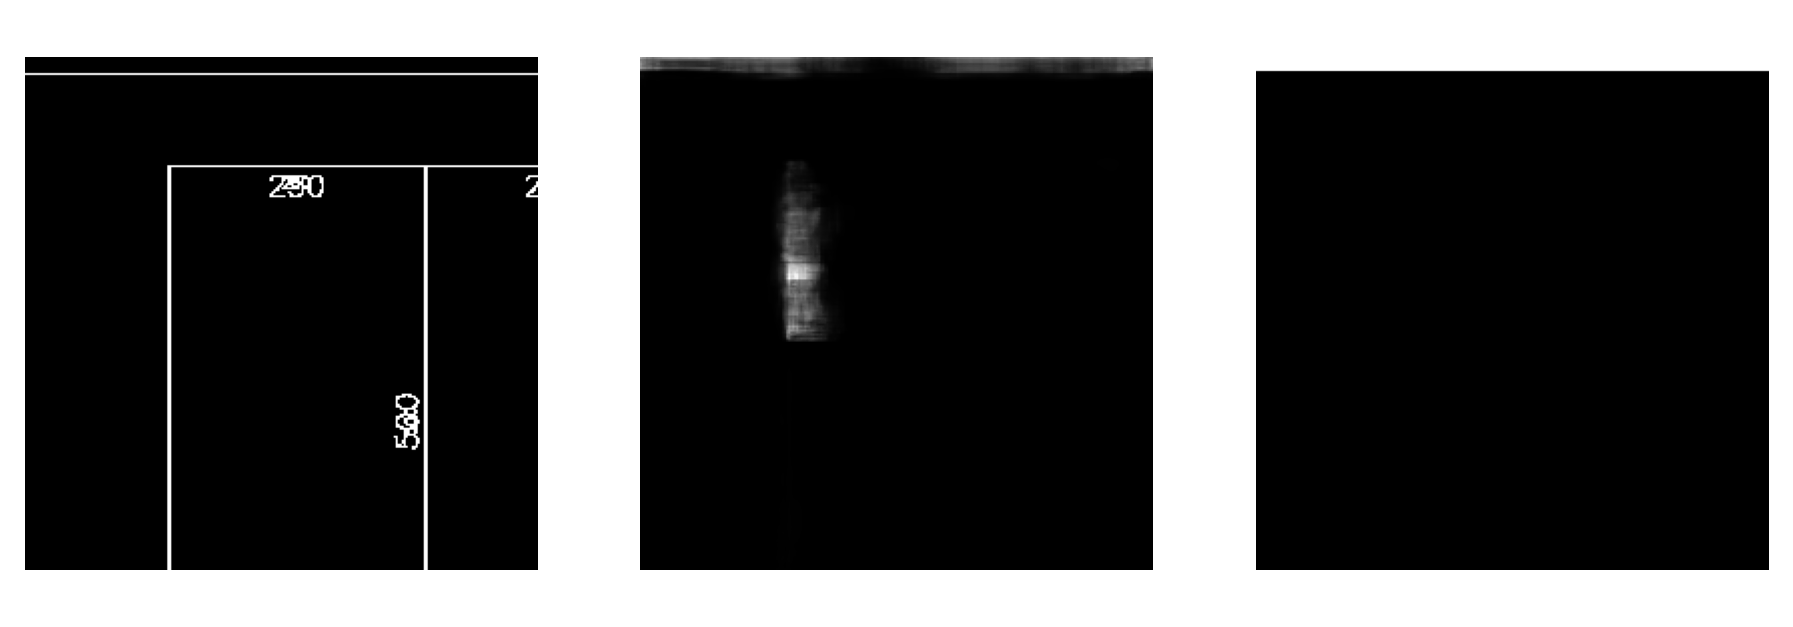

In [35]:
plot_test(3402, False)

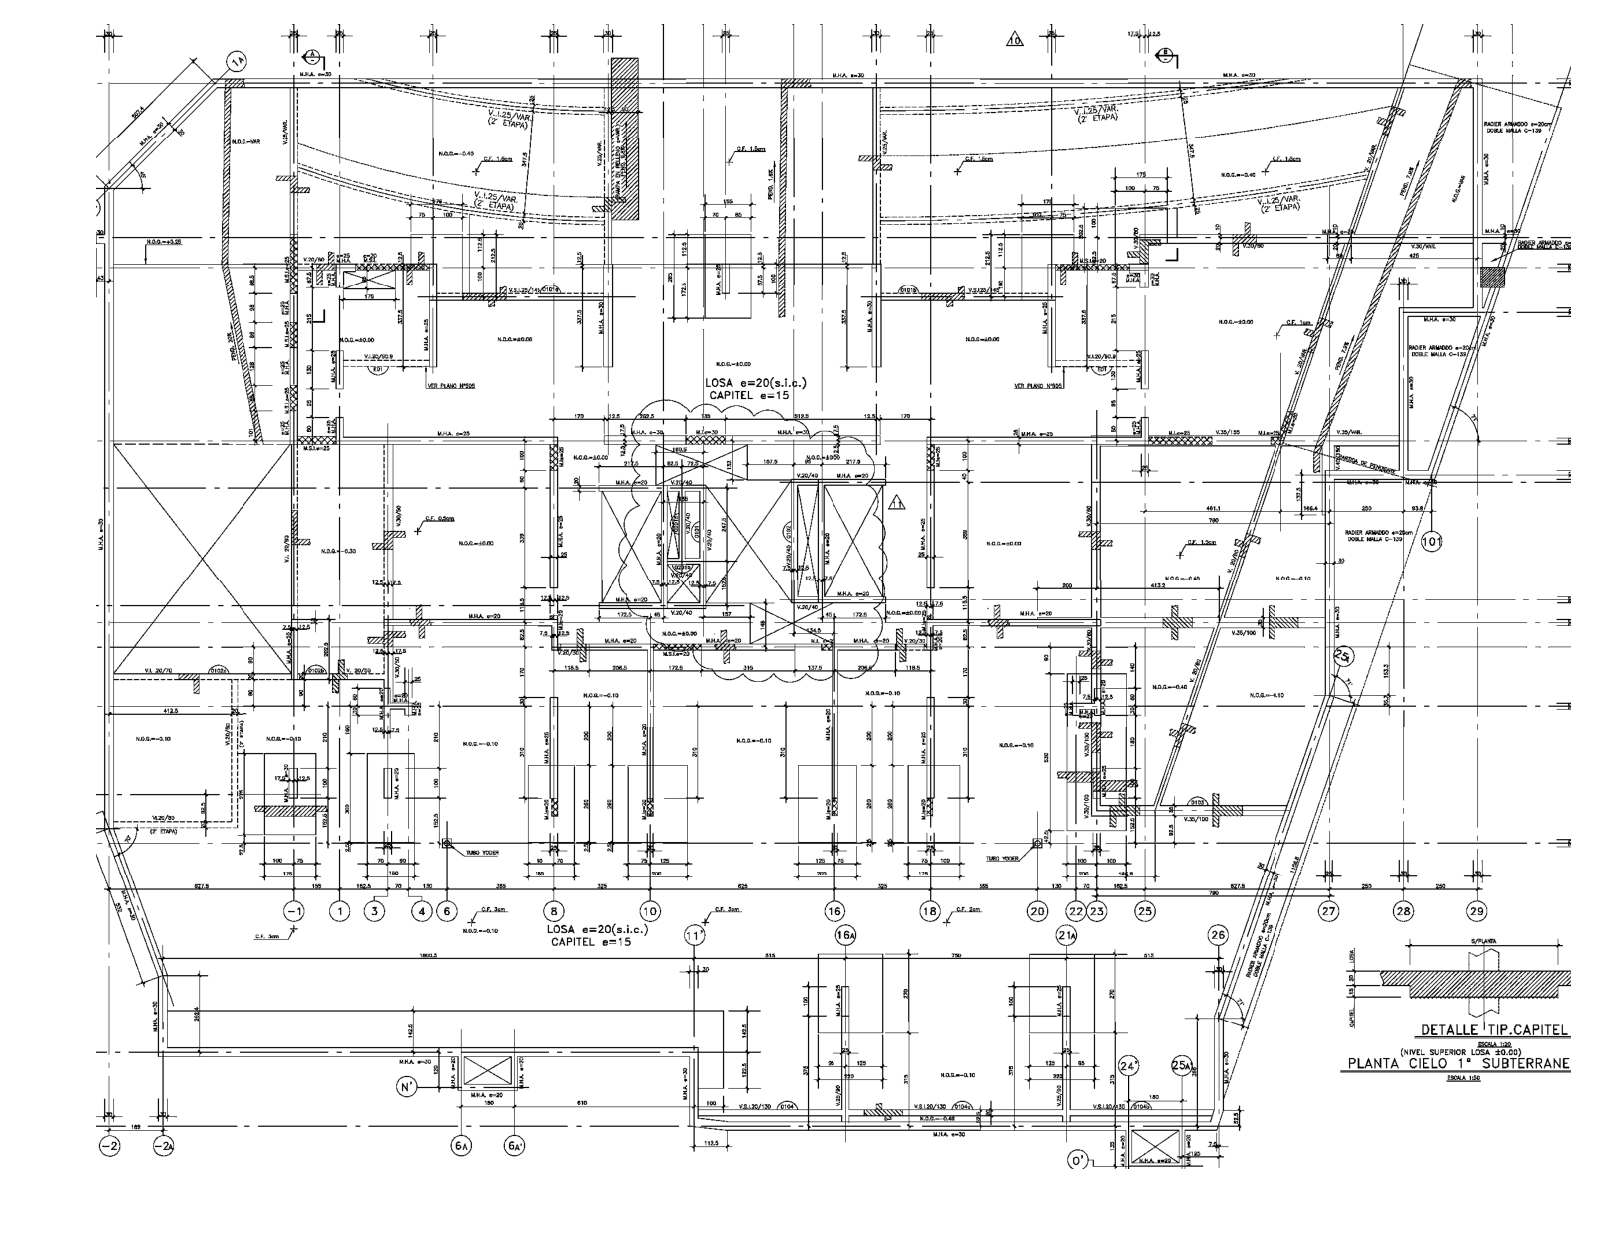

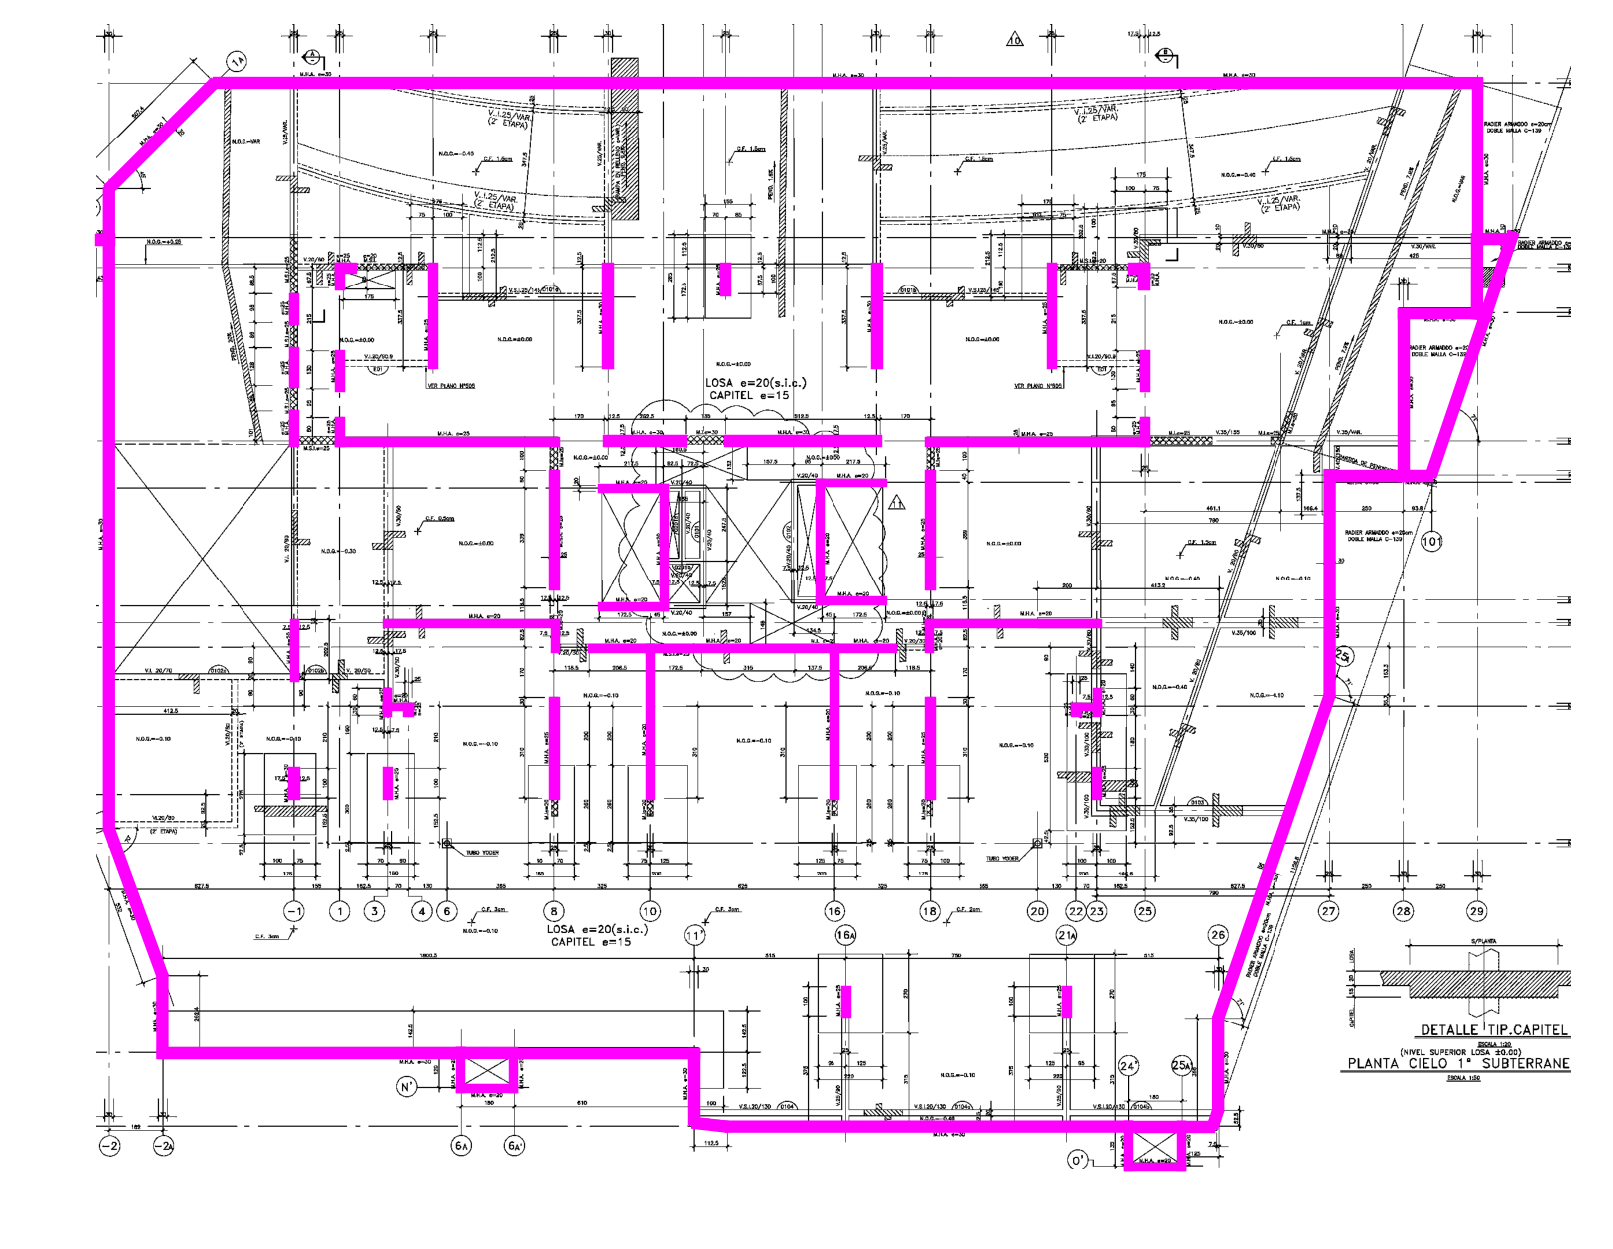

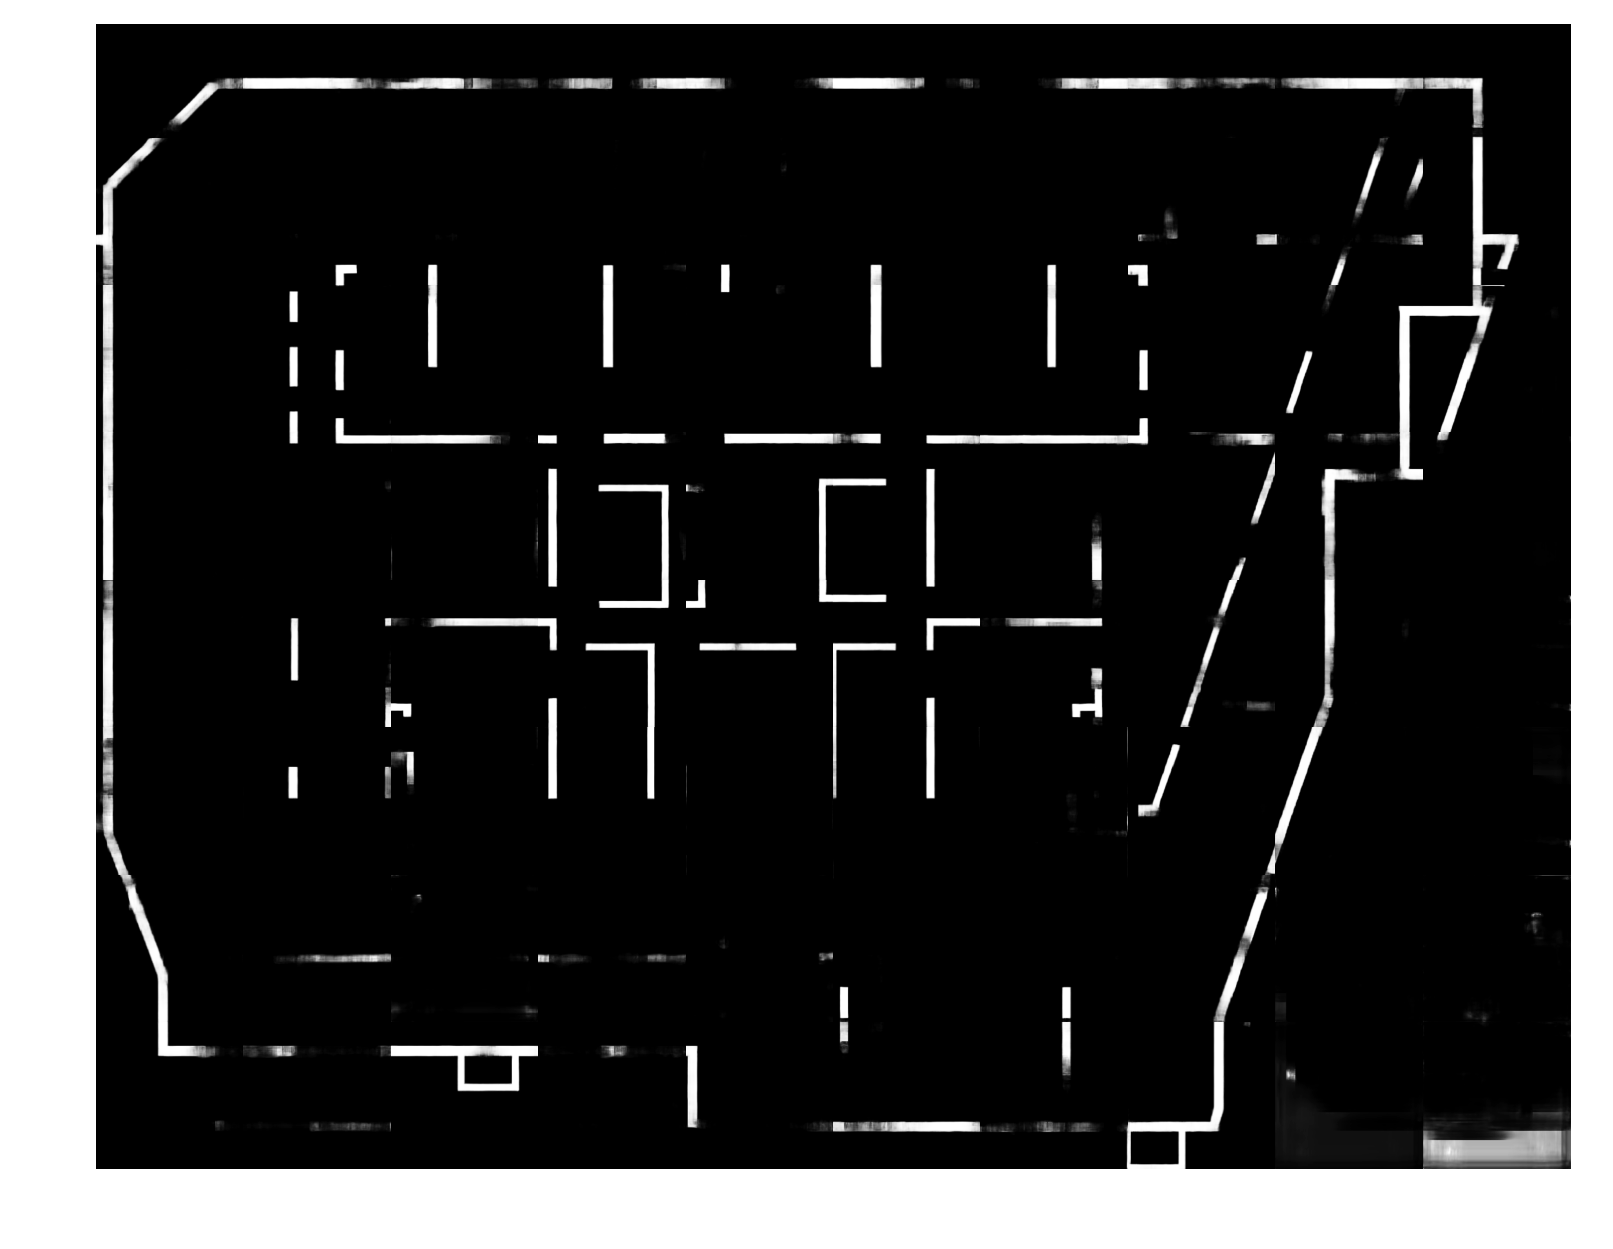

In [471]:
plot_full(190, patch_size=5)

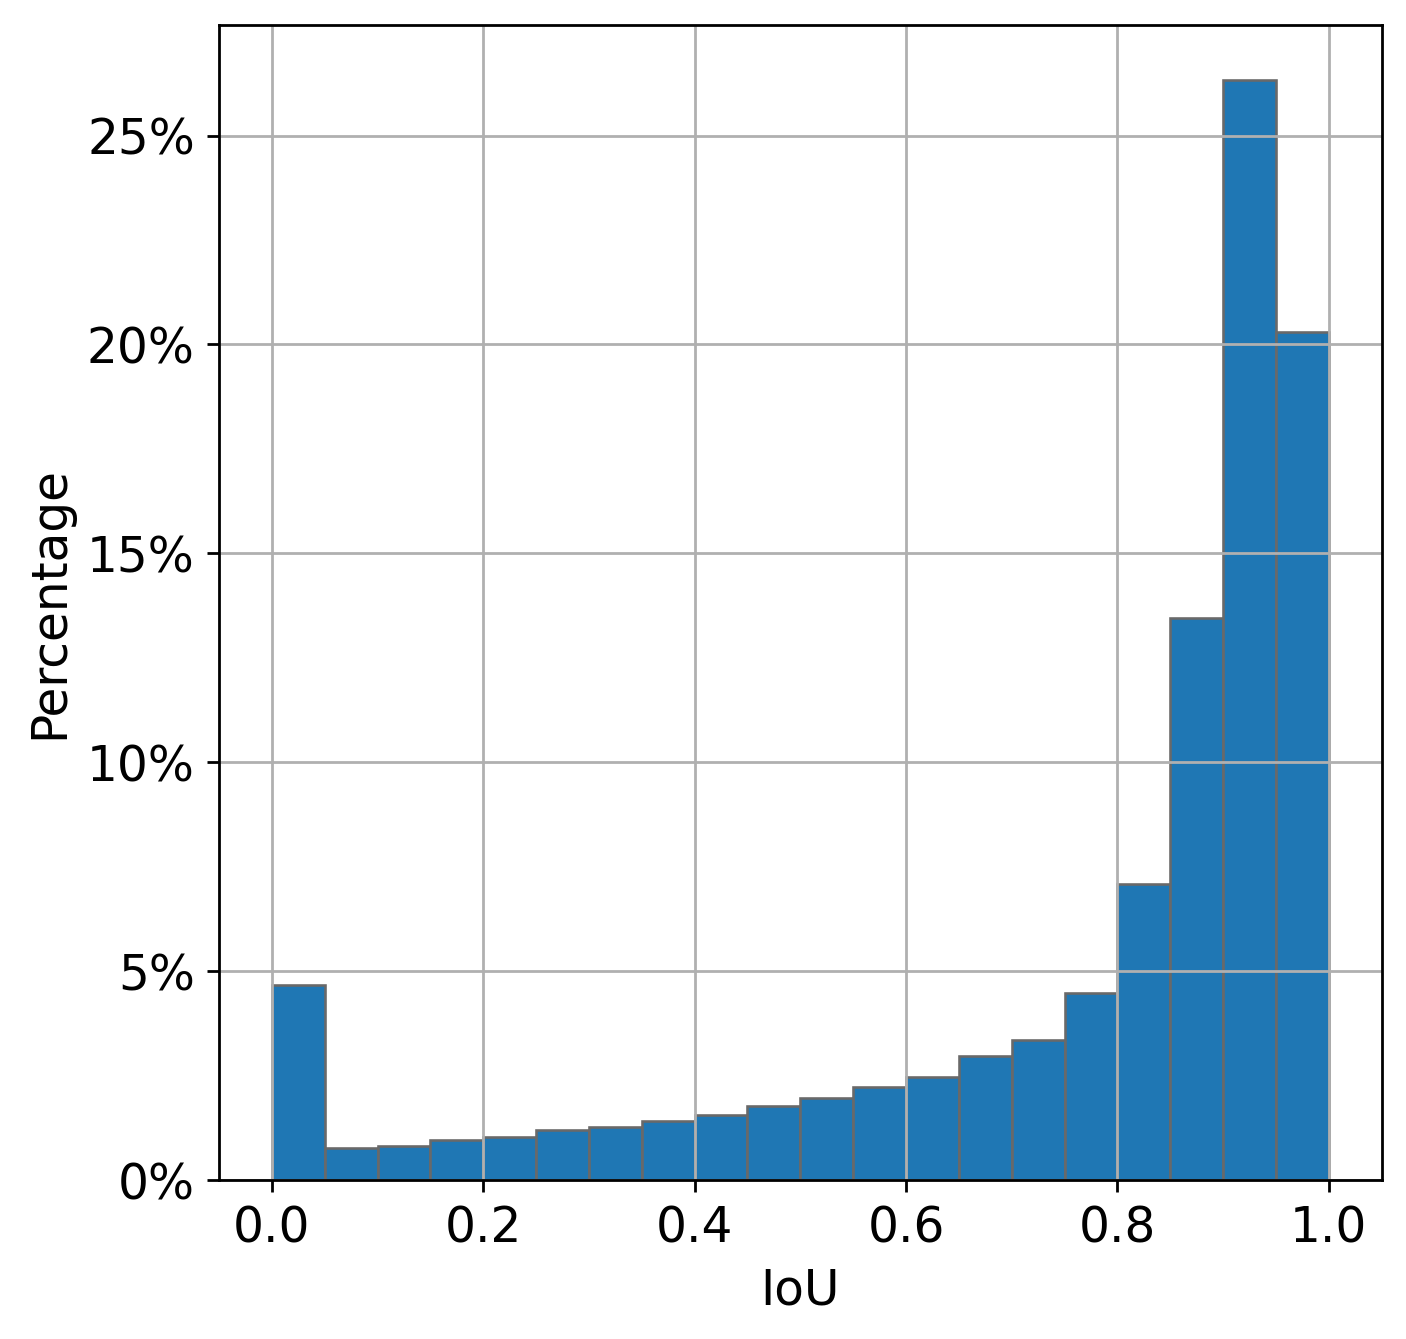

In [34]:
# Compute IoU results
ious = []
for i in tqdm(range(len(test_data['photo']))):
    ious.append(iou_metric(test_data['binary'][i], model.predict_image(test_data['photo'][i])))
print(sum(ious)/len(ious))

plt.figure(figsize=(6, 6), dpi=250)
plt.hist(ious, bins=20, edgecolor='dimgrey', linewidth=0.75, weights=np.ones(len(ious)) / len(ious))
plt.xlabel('IoU')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
# plt.title(title)

ax: 'plt.Axes' = plt.gca()
kwargs = {}
# kwargs['cfg_tight_layout'] = True
f_lbl = kwargs.get('cfg_fontsize_label', 14)
f_tik = kwargs.get('cfg_fontsize_ticks', 14)
ax.yaxis.label.set_size(40)

# Configure label size
ax.xaxis.label.set_size(f_lbl)
ax.yaxis.label.set_size(f_lbl)

# Configure ticks size
plt.xticks(fontsize=f_tik)
plt.yticks(fontsize=f_tik)

# Configure grid
if kwargs.get('cfg_grid', True):
    plt.grid(True)

# Rotate ticks
rot_xticks = kwargs.get('cfg_xticks_rotation', 0)
rot_yticks = kwargs.get('cfg_yticks_rotation', 0)
if rot_xticks != 0:
    plt.xticks(rotation=rot_xticks)
if rot_yticks != 0:
    plt.xticks(rotation=rot_yticks)

if kwargs.get('cfg_equal_axis', False):
    plt.axis('square')
plt.savefig('iou.eps')
plt.show()

## Save the model

In [67]:
model.save_session(f'.session/model_{data.filename}')

Saving session to: .session/model_no_rot_64_175
